In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from macro_agent import MacroAgent, ReplayMemory, QNetwork, Transition
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional
#from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as datetime
from datetime import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

In [2]:
CAPACITY = 500
INIT_EPSILON = 1
_E = 0.00001
GAMMA_DISCOUNT = 0.5
EPOCH_COUNT = 500
MINI_BATCH_SIZE = 10
WINDOW_SIZE = 20
ALPHA = 10000
ACTIONS={"HOLD":torch.tensor([0,1,0], dtype=torch.float32),
"BUY":torch.tensor([1,0,0], dtype=torch.float32), 
  "SELL":torch.tensor([0,0,1], dtype=torch.float32)}

np.random.seed(1000)
import random
random.seed(1000)
torch.manual_seed(1000)

In [3]:
class Environment:
    
    def __init__(self, all_data):
        self._all_data = all_data
        self._pointer = WINDOW_SIZE
        self.done = False
        
        pass

    def taken_action(self):
        self._pointer += 1
        if self._pointer >= len(self._all_data) - 1:
            self.done = True
        pass
    
    def get_price(self):
        return self._all_data.iloc[self._pointer]['Close']

    def get_change_zscore(self, column):
        start_idx = np.max([0, self._pointer - WINDOW_SIZE])
        frame = self._all_data.iloc[start_idx:self._pointer + 1]
        market_now = self._all_data.iloc[self._pointer]
        PC = market_now[column] / np.mean(frame[column]) - 1

        PCs = np.empty_like(frame[column])
        for i in range(start_idx, self._pointer + 1):
            start_frame = np.max([0, i - WINDOW_SIZE])
            end_frame = i
            PCs[i - start_idx] = self._all_data.iloc[end_frame][column] / np.mean(
                self._all_data.iloc[start_frame:end_frame+1][column]) - 1

        z_score_price_change = (PC - np.mean(PCs)) / np.std(PCs) 
        return z_score_price_change

    def get_EMA(self, t):
        start_idx = np.max([0, self._pointer - WINDOW_SIZE])
        g = 2 * self._all_data.iloc[t]['Close'] / (WINDOW_SIZE + 1)
        ex = (100 - 2/(WINDOW_SIZE + 1))
        EMA = g + np.mean(self._all_data.iloc[start_idx:t+1]['Close']) * ex
        return EMA
        

    def get_indicators(self):
        start_idx = np.max([0, self._pointer - WINDOW_SIZE])
        market_now = self._all_data.iloc[self._pointer]
        frame = self._all_data.iloc[start_idx:self._pointer + 1]
        # price
        z_score_price = (market_now['Close'] - 
            np.mean(frame['Close'])) / np.std(frame['Close']) + _E
        # price change
        z_score_price_change = self.get_change_zscore('Close') + _E
        # volume
        z_score_volume = (market_now['Volume'] - 
            np.mean(frame['Volume'])) / np.std(frame['Volume']) + _E
        # volume change
        z_score_volume_change = self.get_change_zscore('Volume') + _E
        # Volatility
        volatility = (self.get_EMA(self._pointer) -
         self.get_EMA(self._pointer - WINDOW_SIZE))/ self.get_EMA(self._pointer - WINDOW_SIZE) + _E
        return z_score_price,z_score_price_change,z_score_volume,z_score_volume_change,volatility

    def get_state(self, agent:MacroAgent):
        return torch.tensor(np.hstack((self.get_price(), self.get_indicators(),
            agent.estimate_assets(self.get_price()))), dtype=torch.float32)

def decay_epsilon(cur_epsilon):
    return cur_epsilon * 0.999

In [4]:
def load_data():
    market_data = pd.read_json('RESULT.json')
    market_data.rename(columns={1:'Open',2:'High', 3:'Low', 4:'Close', 5:'Volume'}, inplace=True)
    market_data[0] = market_data[0].transform(datetime.fromtimestamp)
    market_data.set_index([0], inplace=True)
    market_data.sort_index(inplace=True)
    market_data = market_data[(market_data.index >= '2018-11-15 00:00:00') & (market_data.index <= '2018-11-17 17:06:00')]
    return market_data

def get_train_data(market_data):
    return market_data[market_data.index <= '2018-11-16 00:00:00']

def get_test_data(market_data):
    return market_data[market_data.index >= '2018-11-16 00:00:00']
    

In [5]:
def calculate_reward(chosen_action, estimated_assets):
    if torch.allclose(chosen_action,ACTIONS['SELL']):
        if  estimated_assets == 0:
            return -1
        else: 
            return 1 if estimated_assets > 0 else -1
    elif torch.allclose(chosen_action,ACTIONS['BUY']):
        return 0
    else:
        return 0

def get_best_reward(next_state):
    sell_reward = calculate_reward(ACTIONS['SELL'], next_state[6])
    buy_reward = calculate_reward(ACTIONS['BUY'], next_state[6])
    hold_reward = calculate_reward(ACTIONS['HOLD'], next_state[6])
    if sell_reward >= buy_reward and  sell_reward >= hold_reward:
        return (ACTIONS['SELL'], sell_reward)
    elif buy_reward >= sell_reward and buy_reward >= hold_reward:
        return (ACTIONS['BUY'], buy_reward)
    else:
        return (ACTIONS['HOLD'], hold_reward)

            

In [10]:
replay_memory = ReplayMemory(CAPACITY)
macro_agent = MacroAgent()
from torch.optim.lr_scheduler import ExponentialLR

optimizer = torch.optim.Adam(macro_agent.q_network.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.99)

criterion = nn.MSELoss()

In [13]:

market_data = load_data()
train_data = get_train_data(market_data)
test_data = get_test_data(market_data)
current_max_balance = 0


for epoch in tqdm(range(EPOCH_COUNT)):
    done = False
    cur_epsilon = INIT_EPSILON
    environment = Environment(train_data)
    macro_agent.sell_assets(0)
    optimizer = torch.optim.Adam(macro_agent.q_network.parameters(), lr=0.001, weight_decay=1e-2)
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    while not done:
        now_state = environment.get_state(macro_agent)
        macro_agent.q_network.eval()
        decision = np.random.rand()
        if decision < cur_epsilon:
            # epsilon
            action = ACTIONS[np.random.choice(list(ACTIONS))]
            est_assets = macro_agent.estimate_assets(environment.get_price())
            cur_reward = calculate_reward(action, est_assets)
        else:
            # 1-epsilon
            action, cur_reward = macro_agent.q_network(now_state)
        

        # reward algo
        environment.taken_action()
        next_state = environment.get_state(macro_agent)
        done = environment.done
        
        replay_memory.push(now_state, action, cur_reward, next_state, done)
        
        # taking batch
        batch = replay_memory.sample(MINI_BATCH_SIZE)
        q = []
        true_actions = []
        current_states_batch = []

        for i, object in enumerate(batch):
            current_states_batch.append(object.state)
            if not object.done:
                # r_i + gamma * Q()
                true_actions.append(object.action + GAMMA_DISCOUNT * get_best_reward(object.next_state)[0])
                q.append(object.reward + GAMMA_DISCOUNT * get_best_reward(object.next_state)[1])
            else:
                # r_i
                true_actions.append(object.action)
                q.append(object.reward)
        # grad d
        macro_agent.q_network.train()
        rewards = []
        actions = []
        for batch_state in current_states_batch:
            rewards.append(macro_agent.q_network(batch_state)[1])
            actions.append(macro_agent.q_network.DQN_SMAX(batch_state))
            

        #optimizer.zero_grad()
        for i in range(len(rewards)):
            #print(actions[i])
            if rewards[i] != q[i]:
                loss = criterion(actions[i], true_actions[i]) 
                loss.backward()
        
        optimizer.step()
        scheduler.step()
        cur_epsilon = decay_epsilon(cur_epsilon)  
    
    if epoch % 5 == 0:
        # test model
        macro_agent.q_network.eval()
        test_env = Environment(test_data)
        macro_agent.sell_assets(price=0)
        current_balance = [0.0]
        while not test_env.done:
            now_state = test_env.get_state(macro_agent)
            action, _ = macro_agent.q_network(now_state)
            price = test_env.get_price()
            if torch.allclose(action, ACTIONS['BUY']):
                #print('time to buy')
                prev_assets = macro_agent.estimate_assets(price)
                macro_agent.buy_asset(price)
                after_assets = macro_agent.estimate_assets(price)
                current_balance.append(current_balance[-1] - prev_assets + after_assets)
            elif torch.allclose(action,ACTIONS['SELL']):
                #print('time to sell')
                earning = macro_agent.sell_assets(price)
                current_balance.append(current_balance[-1] + earning)
            else:
                #print('time to hold')
                current_balance.append(current_balance[-1])
            test_env.taken_action()
        plt.plot(current_balance)
        pd.DataFrame(current_balance).to_csv('macro_agent_epoch_{}.csv'.format(epoch))
        plt.savefig('testing_epoch_{}.jpg'.format(epoch))
        if current_balance[-1] > current_max_balance:
            torch.save(macro_agent.q_network.state_dict(), 'q_net_epoch_{}'.format(epoch))

 30%|██▉       | 149/500 [9:34:02<338:44:58, 3474.35s/it]

In [17]:
for param in optimizer.param_groups[0]['params']:
    if param.requires_grad:
        print(param.grad)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.4715e+01, -1.0813e-02, -1.8710e-02, -2.5174e-03, -1.8232e-03,
          1.9214e-06,  0.0000e+00],
        [ 7.1231e+01, -8.1507e-03, -1.4112e-02, -1.8872e-03, -1.3655e-03,
          1.4436e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.7185e+02,  1.9685e-02,  3.4093e-02,  4.5381e-03,  3.2852e-03,
         -3.4757e-06,  0.0000e+00],
        [-1.6010e+01,  1.9500e-03,  3.4311e-03,  3.7129e-04,  2.6617e-04,
         -3.0391e-07,  0.0000e+00],
        [ 1.2504e+02, -1.4153e-02, -2.4434e-02, -3.3787e-03, -2.4492e-03,
          2.5587e-06,  0.0000e+00]])
tensor([ 0.0000,  0.0171,  0.0128,  0.0000, -0.0310, -0.0029,  0.0226])
tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000],
        [   0.0000,   39.4244,    1.3475,    0.0000,   18.423

In [17]:
ACTIONS[np.random.choice(list(ACTIONS))]

tensor([0., 0., 1.])

In [18]:
macro_agent.q_network.eval()
test_env = Environment(test_data)
macro_agent.sell_assets(price=0)
current_balance = [0.0]
while not test_env.done:
    now_state = test_env.get_state(macro_agent)
    action, _ = macro_agent.q_network(now_state)
    price = test_env.get_price()
    if torch.allclose(action, ACTIONS['BUY']):
        print('time to buy')
        prev_assets = macro_agent.estimate_assets(price)
        macro_agent.buy_asset(price)
        after_assets = macro_agent.estimate_assets(price)
        current_balance.append(current_balance[-1] + price)
    elif torch.allclose(action,ACTIONS['SELL']):
        print('time to sell')
        earning = macro_agent.sell_assets(price)
        current_balance.append(current_balance[-1] + earning)
    else:
        print('time to hold')
        current_balance.append(current_balance[-1])
    test_env.taken_action()
plt.plot(current_balance)
pd.DataFrame(current_balance).to_csv('macro_agent_epoch_{}.csv'.format(epoch))
plt.savefig('testing_epoch_{}.jpg'.format(epoch))

time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold
time to hold

KeyboardInterrupt: 

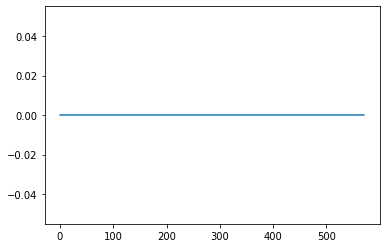

In [19]:
plt.plot(current_balance)

In [21]:
now_state = test_env.get_state(macro_agent)
macro_agent.q_network(now_state)

(tensor([0., 1., 0.]), 0)